# **Movie Recommender System**

Welcome to the **Movie Recommender System** project!  
In this notebook, we’ll build a **hybrid recommender system** that combines:

- **Content-Based Filtering** (recommend movies based on genre similarity).
- **Collaborative Filtering** (recommend movies based on user rating patterns).

---

###  Project Goal

- **Input:** A movie title (e.g., *"Toy Story (1995)"*).  
- **Output:** Top 5 recommended movies.

---

###  Dataset: MovieLens 100k

We’ll use the **MovieLens 100k dataset**, which contains:

- **100,000 ratings**
- **943 users**
- **1682 movies**

This dataset is widely used in recommender system research and benchmarks.

---

###  Roadmap

1. **Setup & Dataset** (load + clean data)
2. **Exploratory Data Analysis (EDA)**
3. **Content-Based Filtering**
4. **Collaborative Filtering**
5. **Hybrid Recommender**
6. **Evaluation**



## **Setup & Dataset**

In this step, we will:

- Load the **ratings file (`u.data`)**
- Load the **movies file (`u.item`)**
- Merge them into a single DataFrame
- Perform a quick sanity check



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

### Loading  Data .


In [2]:
ratings_columns = ["user_id", "movie_id", "rating", "timestamp"]

ratings = pd.read_csv(
    "data/u.data", 
    sep="\t", 
    names=ratings_columns, 
    encoding="latin-1"
)

print("Ratings DataFrame shape:", ratings.shape)
ratings.head()


Ratings DataFrame shape: (100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
movies_columns = [
    "movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies = pd.read_csv(
    "data/u.item", 
    sep="|", 
    names=movies_columns, 
    encoding="latin-1"
)

print("Movies DataFrame shape:", movies.shape)
movies.head()


Movies DataFrame shape: (1682, 24)


,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Merge Ratings and Movies

We’ll join both DataFrames on **`movie_id`** so each rating has a corresponding movie title.


In [4]:
data = pd.merge(ratings, movies[["movie_id", "title"]], on="movie_id")

print("Merged DataFrame shape:", data.shape)
data.head(10)


Merged DataFrame shape: (100000, 5)


,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
5,298,474,4,884182806,Dr. Strangelove or: How I Learned to Stop Worr...
6,115,265,2,881171488,"Hunt for Red October, The (1990)"
7,253,465,5,891628467,"Jungle Book, The (1994)"
8,305,451,3,886324817,Grease (1978)
9,6,86,3,883603013,"Remains of the Day, The (1993)"


In [5]:
#Quick Stats
print("Unique users:", data['user_id'].nunique())
print("Unique movies:", data['movie_id'].nunique())
print("Average rating:", round(data['rating'].mean(), 2))


Unique users: 943
Unique movies: 1682
Average rating: 3.53


## **Exploratory Data Analysis (EDA)**

Now that we have a clean dataset, let’s explore it!

In this step, we’ll:

- Understand the **distribution of ratings**
- Find **top-rated movies**
- Find **most frequently rated movies**
- Visualize **sparsity of the user–movie matrix**

EDA helps us build intuition about the dataset before applying recommender algorithms.


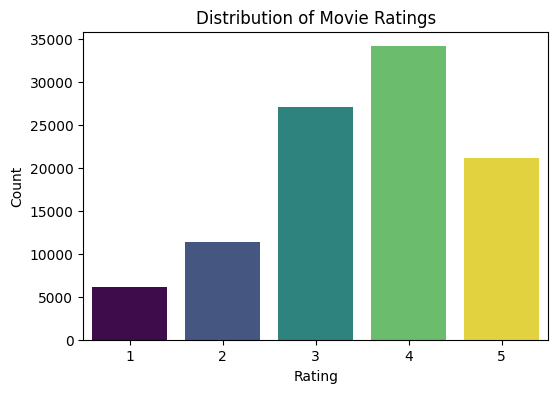

In [6]:
#Ratings Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=data, palette="viridis", hue="rating", legend=False)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [7]:
#Top Rated Movies
movie_stats = data.groupby("title").agg({
    "rating": ["mean", "count"]
})


movie_stats.columns = ["avg_rating", "num_ratings"]
movie_stats = movie_stats.reset_index()

popular_movies = movie_stats[movie_stats["num_ratings"] >= 50]
top_rated = popular_movies.sort_values("avg_rating", ascending=False).head(10)
top_rated


,title,avg_rating,num_ratings
318,"Close Shave, A (1995)",4.491071,112
1281,Schindler's List (1993),4.466443,298
1652,"Wrong Trousers, The (1993)",4.466102,118
273,Casablanca (1942),4.456790,243
1597,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1317,"Shawshank Redemption, The (1994)",4.445230,283
1215,Rear Window (1954),4.387560,209
1572,"Usual Suspects, The (1995)",4.385768,267
1398,Star Wars (1977),4.358491,583
3,12 Angry Men (1957),4.344000,125


In [8]:
#Most Frequently Rated Movies
most_rated = movie_stats.sort_values("num_ratings", ascending=False).head(10)
most_rated


,title,avg_rating,num_ratings
1398,Star Wars (1977),4.358491,583
333,Contact (1997),3.803536,509
498,Fargo (1996),4.155512,508
1234,Return of the Jedi (1983),4.007890,507
860,Liar Liar (1997),3.156701,485
460,"English Patient, The (1996)",3.656965,481
1284,Scream (1996),3.441423,478
1523,Toy Story (1995),3.878319,452
32,Air Force One (1997),3.631090,431
744,Independence Day (ID4) (1996),3.438228,429


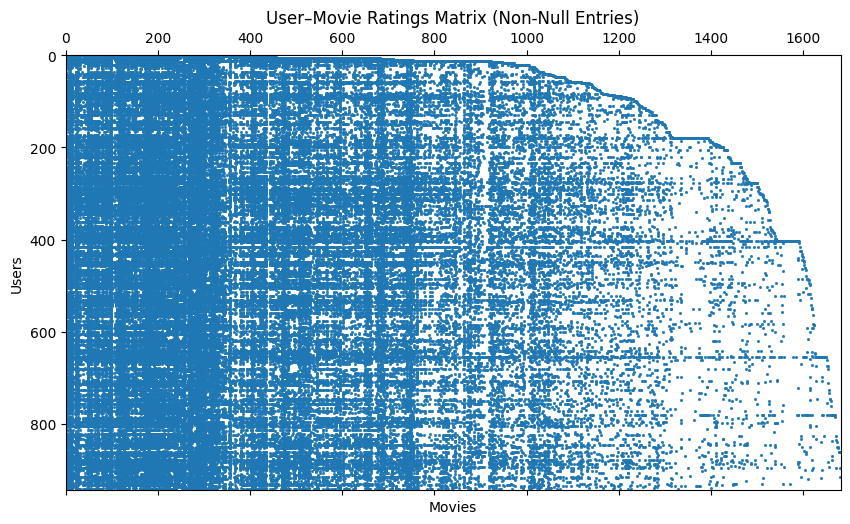

In [9]:
# User–Movie Matrix Sparsity
user_movie_matrix = data.pivot(index="user_id", columns="movie_id", values="rating")

plt.figure(figsize=(10,6))
plt.spy(user_movie_matrix.notnull(), markersize=1)
plt.title("User–Movie Ratings Matrix (Non-Null Entries)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


###  Summary of EDA

 Ratings are mostly around **3–4 stars**  
 Found the **top-rated movies** (with ≥50 ratings)  
 Found the **most-rated movies**  
 Confirmed the dataset is **sparse** (most cells are empty)


# **Content-Based Filtering**

**Goal:** Recommend movies that are **similar in content** (genres) to a given movie.

 Example: If you like *"Toy Story (1995)"*, the system should suggest other **Animation / Family / Comedy** movies.

---

##  How it Works

1. Represent each movie by its **genre vector** (binary flags).
2. Use **cosine similarity** to measure how close two movies are.
3. For a given input movie:
   - Find its genre vector.
   - Compare with all other movies.
   - Return the top N most similar movies.

This method does **not depend on user ratings**, only on movie metadata.


### Extract Genre Features

- Movies dataset has **binary columns** for each genre (e.g., Action, Comedy).
- We’ll use these as features for similarity calculation.


In [11]:
genre_cols = movies.columns[5:]  # skip id, title, release dates, url
genre_features = movies[genre_cols].values

print("Genre features shape:", genre_features.shape)

Genre features shape: (1682, 19)


### Compute Cosine Similarity Matrix

- Each movie is compared with every other movie.
- Result: a **1682 × 1682 similarity matrix**.


In [13]:
cosine_sim = cosine_similarity(genre_features, genre_features)

print("Cosine similarity matrix shape:", cosine_sim.shape)


Cosine similarity matrix shape: (1682, 1682)


### Recommendation Function

We’ll define a function:

```python
def recommend_content_based(movie_title, top_n=5):
````

Steps:

1. Find the index of the input movie.
2. Get similarity scores with all movies.
3. Sort scores in descending order.
4. Return the top `n` most similar movies.

In [14]:
def recommend_content_based(movie_title, top_n=5):
    #check if movie exists
    if movie_title not in movies['title'].values:
        return f"Movie '{movie_title}' not found in dataset."
    
    
    idx = movies[movies['title'] == movie_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #get top N similar movies
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    return movies.iloc[top_indices]['title'].tolist()

### Test the Recommender

Let’s test with some examples:
- `"Toy Story (1995)"`
- `"Star Wars (1977)"`


In [16]:
print("Recommendations for 'Toy Story (1995)':")
print(recommend_content_based("Toy Story (1995)"))

print("\nRecommendations for 'Star Wars (1977)':")
print(recommend_content_based("Star Wars (1977)"))


Recommendations for 'Toy Story (1995)':
['Aladdin and the King of Thieves (1996)', 'Aladdin (1992)', 'Goofy Movie, A (1995)', 'Santa Clause, The (1994)', 'Home Alone (1990)']

Recommendations for 'Star Wars (1977)':
['Return of the Jedi (1983)', 'Empire Strikes Back, The (1980)', 'Starship Troopers (1997)', 'African Queen, The (1951)', 'Stargate (1994)']
